In [2]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
from sklearn.linear_model import LinearRegression


import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.rpcmci import RPCMCI


from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

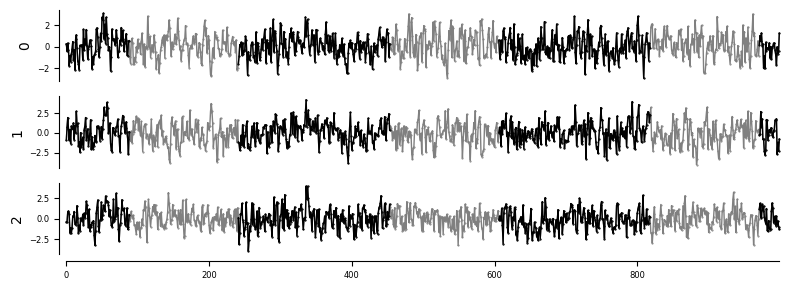

In [10]:
np.random.seed(43)
T = 1000
var_names = [r'$X^1$', r'$X^2$', r'$X^3$']
data = np.random.randn(T, 3)
data_mask = np.zeros(data.shape)
for t in range(1, T):
    if (t % 365) < 3*30 or (t % 365) > 8*30: 
        # Winter half year
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] + 0.7*data[t-1, 0]
        data[t, 2] +=  0.3*data[t-1, 2] + 0.7*data[t-1, 0]
    else:
        # Summer half year
        data_mask[[t, t-1]] = True
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1]  - 0.7*data[t-1, 0]
        data[t, 2] +=  0.3*data[t-1, 2] 

T, N = data.shape
# print data_mask[:100, 0]
datatime = np.arange(T)
dataframe_plotting = pp.DataFrame(data, mask=data_mask)
tp.plot_timeseries(dataframe_plotting, figsize=(8,3), grey_masked_samples='data'); plt.show()

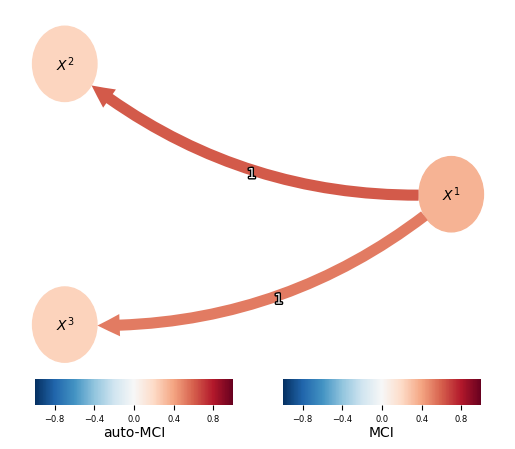

In [11]:
# First mask out the summer
pcmci = PCMCI(dataframe=dataframe_plotting, 
              cond_ind_test=ParCorr(mask_type='y'))
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

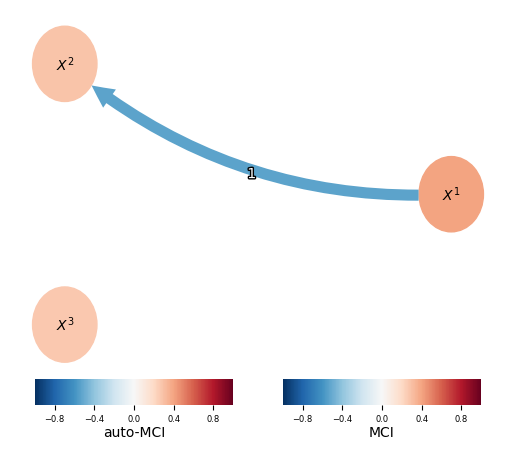

In [12]:
# Then mask out the winter
dataframe_plotting.mask[0] = dataframe_plotting.mask[0] == False
pcmci = PCMCI(dataframe=dataframe_plotting, 
              cond_ind_test=ParCorr(mask_type='y'))
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

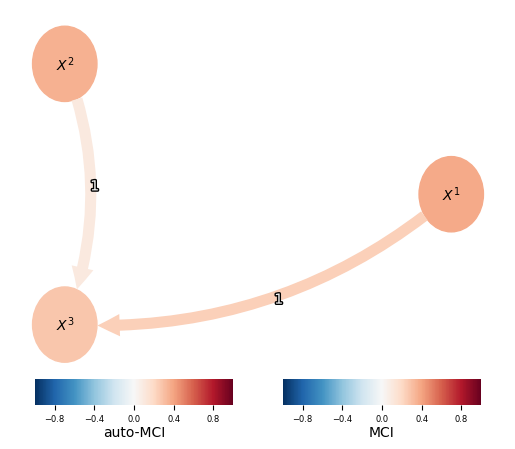

In [13]:
pcmci = PCMCI(dataframe=pp.DataFrame(data), 
              cond_ind_test=ParCorr())
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

In [14]:
# Dataframe init. Note that for R-PCMCI no data mask can be used. 
# The mask will internally be overwritten to learn regimes
dataframe = pp.DataFrame(data)

# Init RPCMCI with the dataframe, a conditional independence test for use in PCMCI, 
# and a prediction_model which is used to predict each variable given its learned parents. This prediction 
# is then used inside the regime learning optimization step.
rpcmci = RPCMCI(dataframe=dataframe, 
                cond_ind_test=ParCorr(),
                prediction_model=LinearRegression(),
                verbosity=1)

# RPCMCI parameters, see paper
num_regimes = 2
max_transitions = 4
switch_thres = 0.05
num_iterations = 20
max_anneal = 10
tau_min = 1
tau_max = 1
pc_alpha = 0.2
alpha_level = 0.01
n_jobs = -1     # uses joblib for parallelization, here all available cpus are used

# Run RPCMCI
results = rpcmci.run_rpcmci(
    num_regimes=num_regimes, max_transitions=max_transitions, 
    switch_thres=switch_thres, 
    num_iterations=num_iterations, max_anneal=max_anneal, 

    tau_min=tau_min, tau_max=tau_max,
    pc_alpha=pc_alpha, alpha_level=alpha_level, 
    n_jobs=n_jobs
    )

if results is None:
    print("All annealings resulted in errors. Increase annealing and tune other parameters!")
else:
    print("Done!")

Done!


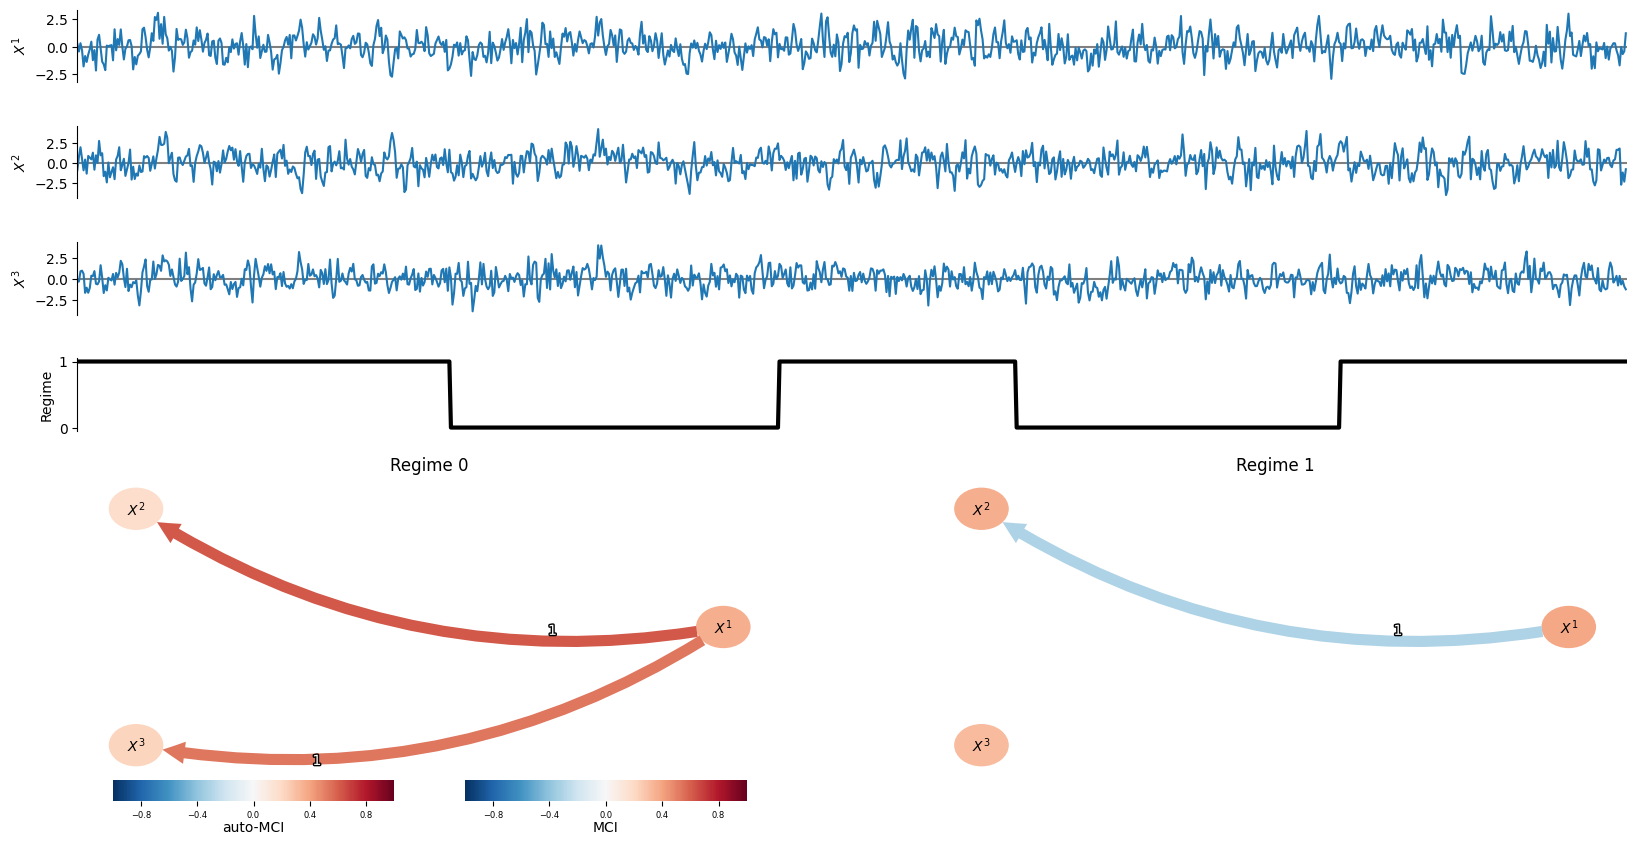

In [15]:
regimes = results['regimes'].argmax(axis=0)
n_regimes = len(results['causal_results'])

# Create nice Mosaic plot
mosaic = [['data %s' %j for i in range(n_regimes)] for j in range(N+1)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_regimes)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    ax.plot(datatime, data[:,j])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])
    
# Regime variable
ax = axs['data %s' %N]
ax.plot(datatime, regimes.astype('int'), lw=3, color='black')
for loc, spine in ax.spines.items():
    if loc != 'left':
        spine.set_color("none")
ax.xaxis.set_ticks([]) 
ax.yaxis.set_ticks(range(n_regimes))   
ax.set_xlim(0., T)
ax.set_ylabel("Regime")
    
# Causal graphs for each regime
for w in range(n_regimes):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graph=results['causal_results'][w]['graph'], 
                  val_matrix=results['causal_results'][w]['val_matrix'], 
                  show_colorbar=show_colorbar,
                  var_names=var_names,
                  fig_ax=(fig, axs['graph %s' %w]))
    axs['graph %s' %w].set_title("Regime %d" %w, pad=-4)

fig.subplots_adjust(hspace=0.6)
plt.show()